<a href="https://colab.research.google.com/github/tinayiluo0322/Computer-Engineering-Machine-Learning-and-Deep-Neural-Nets-Projects/blob/main/LMS_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this lab question, you will implement the LMS algorithm with NumPy to learn a linear regression model for the provided dataset. You will also be directed to analyze how the choice of learning rate in the LMS algorithm affect the final result.

In [15]:
!pip install plotly

In [16]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple

from google.colab import drive

import random
import plotly.graph_objects as go

In [2]:
seed = 42
random.seed(seed)  # Python's random module
np.random.seed(seed)  # NumPy's random module
torch.manual_seed(seed)  # PyTorch's random seed for CPU
torch.cuda.manual_seed(seed)  # PyTorch's random seed for the current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch's random seed for all GPUs (if using multi-GPU)

# Ensure deterministic behavior on GPU (optional, may slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: Set environment variables for further reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the Dataset

To start with, please download the dataset.mat file from Canvas and load it into NumPy arraysa. There are two variables in the file: data X ∈ R100×3 and target D ∈ R100×1. Each individual pair of data and target is composed into X and D following the same way as discussed in Lecture 2. Specifically, each row in X corresponds to the transpose of a data point, with the first element as constant 1 and the other two as the two input features x1k and x2k. The goal of the learning task is finding the weight vector W ∈ R3×1 for the linear model that can minimize the MSE loss, which is also formulated on Lecture 2.

In [4]:
# Load the dataset
data = loadmat('/content/drive/My Drive/dataset.mat')

Shape of X: (100, 3)
Shape of D: (100, 1)

Summary statistics for X:
Mean: [1.         0.08505556 0.04751127]
Min: [ 1.         -3.21704883 -2.21293608]
Max: [1.         2.57229714 2.2751629 ]

Summary statistics for D:
Mean: 0.990747933091121
Min: -3.1297663434681535
Max: 6.2563731719110045


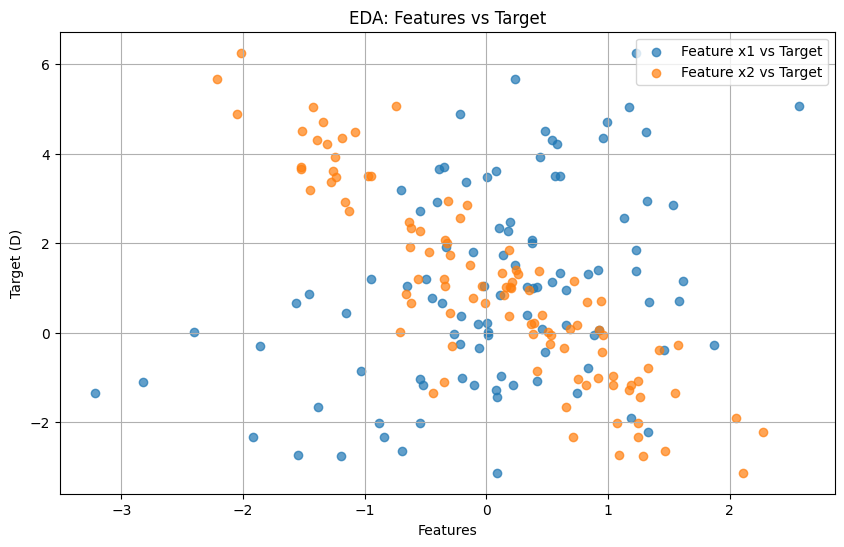

In [5]:
# Extract variables X and D
X = data['X']
D = data['D']

# Print the shape of the dataset
print(f"Shape of X: {X.shape}")  # Should be (100, 3)
print(f"Shape of D: {D.shape}")  # Should be (100, 1)

# Check basic statistics
print("\nSummary statistics for X:")
print(f"Mean: {np.mean(X, axis=0)}")
print(f"Min: {np.min(X, axis=0)}")
print(f"Max: {np.max(X, axis=0)}")

print("\nSummary statistics for D:")
print(f"Mean: {np.mean(D)}")
print(f"Min: {np.min(D)}")
print(f"Max: {np.max(D)}")

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 1], D, label="Feature x1 vs Target", alpha=0.7)
plt.scatter(X[:, 2], D, label="Feature x2 vs Target", alpha=0.7)
plt.title("EDA: Features vs Target")
plt.xlabel("Features")
plt.ylabel("Target (D)")
plt.legend()
plt.grid()
plt.show()

In [8]:
# Convert to pandas DataFrame for better readability
X_df = pd.DataFrame(X, columns=['Bias (1)', 'Feature x1', 'Feature x2'])
D_df = pd.DataFrame(D, columns=['Target D'])

# Combine features and target for display
data_df = pd.concat([X_df, D_df], axis=1)

# display only the first few rows for quick inspection
print("\nFirst 10 rows of the dataset:")
data_df.head(10)


First 10 rows of the dataset:


,Bias (1),Feature x1,Feature x2,Target D
0,1.0,-0.947247,-0.565463,1.196099
1,1.0,0.540150,0.208620,1.123306
2,1.0,-0.216602,-2.050301,4.888902
3,1.0,1.189032,2.048578,-1.904577
4,1.0,1.316988,-0.317208,2.950036
5,1.0,-0.405629,-1.160915,2.915203
6,1.0,-0.444906,-0.110291,0.774014
7,1.0,1.328386,2.275163,-2.222243
8,1.0,0.833803,1.324125,-0.789806
9,1.0,0.604446,-0.949737,3.499646


Directly compute the least square (Wiener) solution with the provided dataset. What is the optimal weight W∗? What is the MSE loss of the whole dataset when the weight is set to W∗?

In [9]:
# Compute the optimal weight W*
X_T = X.T
W_star = np.linalg.inv(X_T @ X) @ X_T @ D

# Display the optimal weight
print("Optimal weight W*:")
print(W_star)

# Compute the MSE loss
n = X.shape[0]  # Number of samples
MSE_loss = np.sum((X @ W_star - D) ** 2) / n

# Display the MSE loss
print(f"\nMSE Loss when W* is used: {MSE_loss:.4f}")

Optimal weight W*:
[[ 1.0006781 ]
 [ 1.00061145]
 [-2.00031968]]

MSE Loss when W* is used: 0.0001


Now consider that you can only train with 1 pair of data points and target each time. In such a case, the LMS algorithm should be used to find the optimal weight. Please initialize the weight vector as W 0 = [0.53, 0.20, 0.10]T , and update the weight with the LMS algorithm. After each epoch (every time you go through all the training data and loop back to the beginning), compute and record the MSE loss of the current weight on the whole dataset. Run LMS for 20 epochs with learning rate r = 0.005, report the weight you get in the end, and plot the MSE loss in log scale vs. Epochs.

Final weight vector W after 20 epochs: [ 1.00070598  1.00059491 -2.00033694]


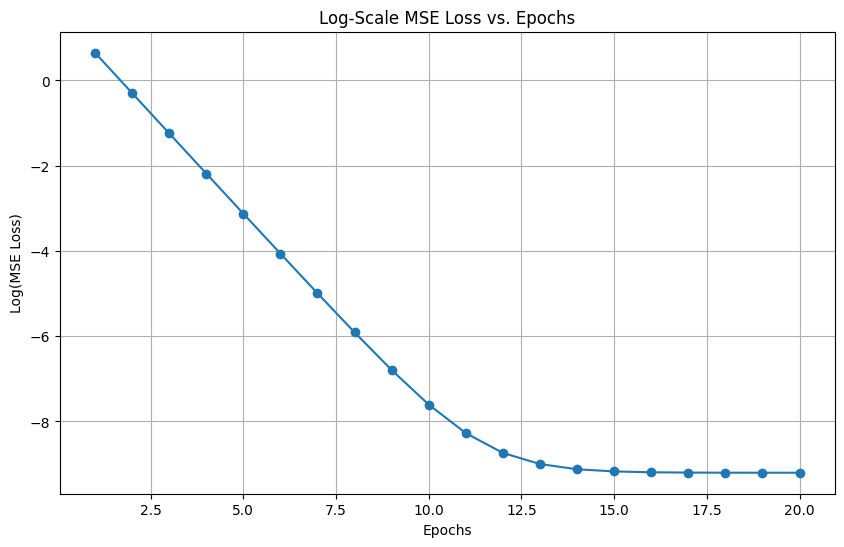

In [10]:
# Initialize parameters
W = np.array([0.53, 0.20, 0.10])  # Initial weight vector W0
learning_rate = 0.005  # Learning rate r
epochs = 20  # Number of epochs
n = X.shape[0]  # Number of data points

# Store MSE loss for each epoch
mse_losses = []

# LMS algorithm
for epoch in range(epochs):
    for i in range(n):
        # Get the current data point and target
        X_i = X[i].reshape(-1, 1)  # Shape (3, 1)
        D_i = D[i]  # Target value

        # Predict and compute the error
        error = D_i - W @ X_i  # Scalar error

        # Update the weight vector
        W = W + learning_rate * error * X_i.flatten()

    # Compute MSE loss for the whole dataset
    predictions = X @ W
    mse_loss = np.mean((D.flatten() - predictions) ** 2)
    mse_losses.append(mse_loss)

# Final weight vector
print(f"Final weight vector W after {epochs} epochs: {W}")

# Plot MSE loss (log scale) vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), np.log(mse_losses), marker='o')
plt.title('Log-Scale MSE Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log(MSE Loss)')
plt.grid()
plt.show()


Scatter plot the points (x1k,x2k,dk) for all 100 data-target pairs in a 3D figureb, and plot the lines corresponding to the linear models you got in (a) and (b) respectively in the same figure. Observe if the linear models fit the data well.

In [21]:
# Extract features and target
x1 = X[:, 1]  # Second column (feature x1)
x2 = X[:, 2]  # Third column (feature x2)
d = D.flatten()  # Target (flatten for easier manipulation)

# Models: Weights from (a) and (b)
W_a = np.array([1.0006781, 1.00061145, -2.00031968])  # Weights for model (a)
W_b = np.array([1.00070598, 1.00059491, -2.00033694])  # Weights for model (b)

# Generate predictions for the planes
x1_range = np.linspace(min(x1), max(x1), 50)
x2_range = np.linspace(min(x2), max(x2), 50)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Plane for model (a): d = W_0 + W_1*x1 + W_2*x2
d_a = W_a[0] + W_a[1] * x1_grid + W_a[2] * x2_grid

# Plane for model (b): d = W_0 + W_1*x1 + W_2*x2
d_b = W_b[0] + W_b[1] * x1_grid + W_b[2] * x2_grid

# Plot for Model (a)
fig_a = go.Figure()

fig_a.add_trace(
    go.Scatter3d(
        x=x1, y=x2, z=d,
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Data Points'
    )
)

fig_a.add_trace(
    go.Surface(
        x=x1_grid, y=x2_grid, z=d_a,
        opacity=0.8,
        colorscale='Reds',
        name='Model (a)',
        showscale=False
    )
)

fig_a.update_layout(
    title="Model (a): Linear Fit",
    scene=dict(
        xaxis_title="Feature x1",
        yaxis_title="Feature x2",
        zaxis_title="Target d"
    )
)

# Plot for Model (b)
fig_b = go.Figure()

fig_b.add_trace(
    go.Scatter3d(
        x=x1, y=x2, z=d,
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Data Points'
    )
)

fig_b.add_trace(
    go.Surface(
        x=x1_grid, y=x2_grid, z=d_b,
        opacity=0.8,
        colorscale='Greens',
        name='Model (b)',
        showscale=False
    )
)

fig_b.update_layout(
    title="Model (b): Linear Fit",
    scene=dict(
        xaxis_title="Feature x1",
        yaxis_title="Feature x2",
        zaxis_title="Target d"
    )
)

# Show both plots
fig_a.show()
fig_b.show()


Learning rate r is an important hyperparameter for the LMS algorithm, as well as for CNN optimization. Here, try repeat the process in (b) with r set to 0.01, 0.05, 0.1 and 0.5 respectively. Together with the result you got in (b), plot the MSE losses of all sets of experiments in log scale vs. Epochs in one figure. Then try further enlarge the learning rate to r = 1 and observe how the MSE changes. Based on these observations, comments on how the learning rate affects the speed and quality of the learning process. (Note: The learning rate tuning for the CNN optimization will be introduced in Lecture 7.)

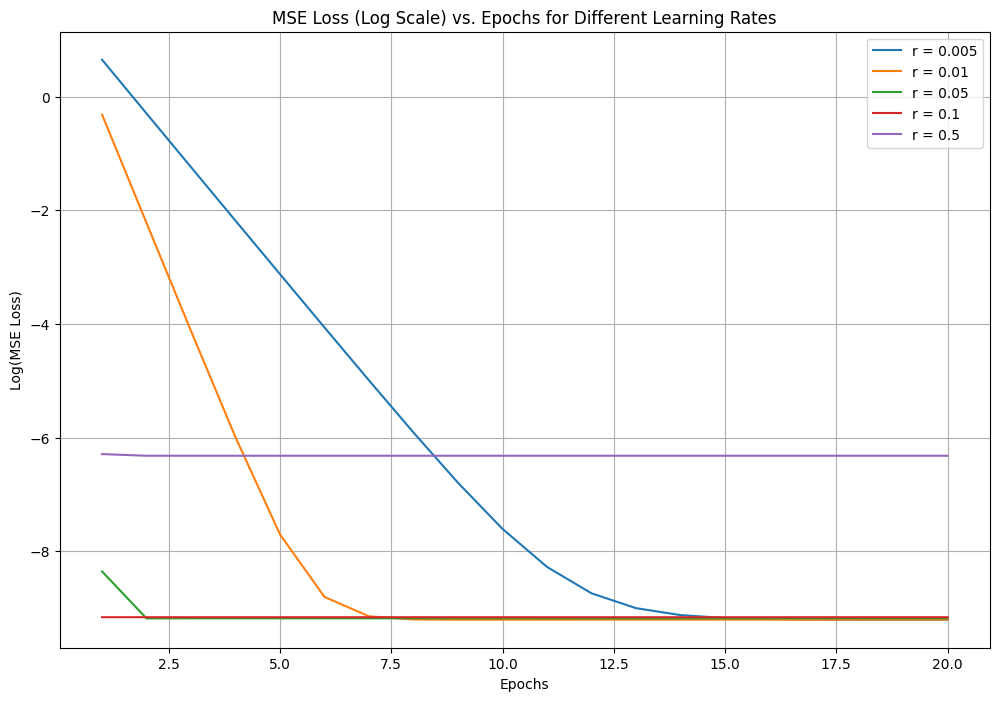

In [23]:
# LMS algorithm function
def LMS(X, D, W_init, learning_rate, epochs):
    n = X.shape[0]  # Number of samples
    W = W_init.copy()  # Initialize weights
    mse_losses = []  # Store MSE losses

    for epoch in range(epochs):
        for i in range(n):
            X_i = X[i].reshape(-1, 1)  # Current feature vector (3x1)
            D_i = D[i]  # Current target
            error = D_i - W @ X_i  # Compute error
            W = W + learning_rate * error * X_i.flatten()  # Update weights

        # Compute MSE for the entire dataset
        predictions = X @ W
        mse_loss = np.mean((D.flatten() - predictions) ** 2)
        mse_losses.append(mse_loss)

    return W, mse_losses

# Experiment parameters
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.5]  # Learning rates to test
epochs = 20  # Number of epochs
W_init = np.array([0.53, 0.20, 0.10])  # Initial weight vector
results = {}  # Store MSE losses for each learning rate

# Run LMS for each learning rate
for r in learning_rates:
    _, mse_losses = LMS(X, D, W_init, r, epochs)
    results[r] = mse_losses

# Plot MSE losses in log scale vs. Epochs
plt.figure(figsize=(12, 8))
for r, mse_losses in results.items():
    plt.plot(range(1, epochs + 1), np.log(mse_losses), label=f'r = {r}')
plt.title('MSE Loss (Log Scale) vs. Epochs for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Log(MSE Loss)')
plt.legend()
plt.grid()
plt.show()

<ipython-input-24-55e3113d88a0>:25: RuntimeWarning:

overflow encountered in square



Final weight vector W after 20 epochs: [ 1.95487304e+188 -6.24334547e+187 -2.03456405e+188]


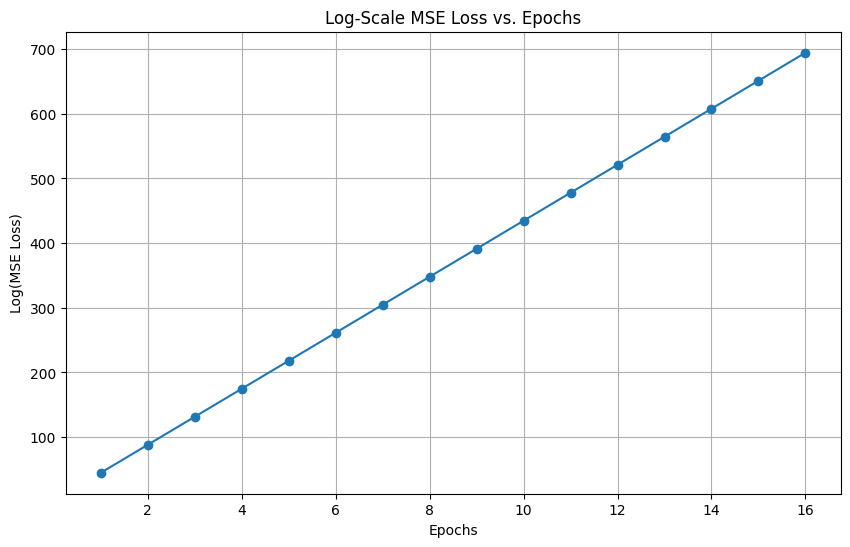

In [24]:
# Initialize parameters
W = np.array([0.53, 0.20, 0.10])  # Initial weight vector W0
learning_rate = 1  # Learning rate r
epochs = 20  # Number of epochs
n = X.shape[0]  # Number of data points

# Store MSE loss for each epoch
mse_losses = []

# LMS algorithm
for epoch in range(epochs):
    for i in range(n):
        # Get the current data point and target
        X_i = X[i].reshape(-1, 1)  # Shape (3, 1)
        D_i = D[i]  # Target value

        # Predict and compute the error
        error = D_i - W @ X_i  # Scalar error

        # Update the weight vector
        W = W + learning_rate * error * X_i.flatten()

    # Compute MSE loss for the whole dataset
    predictions = X @ W
    mse_loss = np.mean((D.flatten() - predictions) ** 2)
    mse_losses.append(mse_loss)

# Final weight vector
print(f"Final weight vector W after {epochs} epochs: {W}")

# Plot MSE loss (log scale) vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), np.log(mse_losses), marker='o')
plt.title('Log-Scale MSE Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log(MSE Loss)')
plt.grid()
plt.show()